In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION' ] = 'python'

In [2]:
from lass.log_handling import LogLoaderArgs, LogLoader
from lass.data.loading import get_query_type


args = LogLoaderArgs(
    logdir="../artifacts/logs",
    tasks="paper-full",
    model_families=["BIG-G T=0"],
    model_sizes=["128b"],
    # model_sizes=["2m"],
    shots=[3],
    # query_types=["multiple_choice"],
)
loader = LogLoader(args)

In [3]:
tasks = list(loader.load_per_task())

### Count the number of tasks with queries of specific question types
The options are multiple choice, generative, and scoring.

In [4]:
from collections import defaultdict

task_types = defaultdict(list)
for task in tasks:
    run = task[list(task.keys())[0]]
    types = [get_query_type(query) for query in (run.queries or [])]
    for type_ in set(types):
        task_types[type_].append(run.task.task_name)

    if len(set(types)) > 1:
        task_types["mixed"].append(run.task.task_name)

{key: len(value) for key, value in task_types.items()}

# For 3-shot it's {'multiple_choice': 118, 'generative': 54, 'mixed': 54, 'scoring': 53}
# For 0-shot it's {'multiple_choice': 118, 'generative': 54, 'mixed': 54, 'scoring': 68}

{'multiple_choice': 118, 'generative': 54, 'mixed': 54, 'scoring': 68}

### Example Tasks

In [5]:
task_types["multiple_choice"][:10]

['abstract_narrative_understanding',
 'anachronisms',
 'analogical_similarity',
 'analytic_entailment',
 'arithmetic',
 'authorship_verification',
 'bbq_lite_json',
 'causal_judgment',
 'cause_and_effect',
 'checkmate_in_one']

In [6]:
task_types["generative"][:10]

['arithmetic',
 'ascii_word_recognition',
 'auto_categorization',
 'auto_debugging',
 'bridging_anaphora_resolution_barqa',
 'checkmate_in_one',
 'chess_state_tracking',
 'chinese_remainder_theorem',
 'codenames',
 'color']

In [7]:
task_types["scoring"][:10]

['ascii_word_recognition',
 'auto_categorization',
 'auto_debugging',
 'bbq_lite',
 'bias_from_probabilities',
 'boolean_expressions',
 'bridging_anaphora_resolution_barqa',
 'checkmate_in_one',
 'chess_state_tracking',
 'chinese_remainder_theorem']

In [8]:
task_types["mixed"][:10]

['arithmetic',
 'ascii_word_recognition',
 'auto_categorization',
 'auto_debugging',
 'bridging_anaphora_resolution_barqa',
 'checkmate_in_one',
 'chess_state_tracking',
 'chinese_remainder_theorem',
 'codenames',
 'color']

### Validate disjoint sets

In [9]:
generative_non_mpc = set(task_types["generative"]) - set(task_types["multiple_choice"])
generative_non_scoring = set(task_types["generative"]) - set(task_types["scoring"])
generative_only = set(task_types["generative"]) - set(task_types["mixed"])
scoring_non_generative = set(task_types["scoring"]) - set(task_types["generative"])
scoring_non_mpc = set(task_types["scoring"]) - set(task_types["multiple_choice"])
scoring_only = set(task_types["scoring"]) - set(task_types["mixed"])
mpc_only = set(task_types["multiple_choice"]) - set(task_types["mixed"])
all_tasks = set(task_types["multiple_choice"]) | set(task_types["generative"]) | set(task_types["scoring"])

All generative tasks are mixed tasks.

In [10]:
len(generative_only)

0

... and there is only one task that is generative, but not a scoring task.

In [11]:
print(len(generative_non_scoring), generative_non_scoring)

1 {'arithmetic'}


While there are multiple 'scoring' tasks that are not generative.

In [12]:
print(len(scoring_non_generative), sorted(list(scoring_non_generative)))
print(len(scoring_only), sorted(list(scoring_only)))
print(len(scoring_non_mpc), sorted(list(scoring_non_mpc)))

15 ['bbq_lite', 'bias_from_probabilities', 'boolean_expressions', 'com2sense', 'diverse_social_bias', 'dynamic_counting', 'factuality_of_summary', 'forecasting_subquestions', 'gender_sensitivity_chinese', 'gender_sensitivity_english', 'protein_interacting_sites', 'subject_verb_agreement', 'talkdown', 'unqover', 'web_of_lies']
15 ['bbq_lite', 'bias_from_probabilities', 'boolean_expressions', 'com2sense', 'diverse_social_bias', 'dynamic_counting', 'factuality_of_summary', 'forecasting_subquestions', 'gender_sensitivity_chinese', 'gender_sensitivity_english', 'protein_interacting_sites', 'subject_verb_agreement', 'talkdown', 'unqover', 'web_of_lies']
58 ['ascii_word_recognition', 'auto_categorization', 'auto_debugging', 'bbq_lite', 'bias_from_probabilities', 'boolean_expressions', 'bridging_anaphora_resolution_barqa', 'chess_state_tracking', 'chinese_remainder_theorem', 'codenames', 'com2sense', 'conlang_translation', 'cryptonite', 'disfl_qa', 'diverse_social_bias', 'dynamic_counting', 'f

In [13]:
generative_non_mpc.intersection(scoring_non_mpc) | mpc_only

{'abstract_narrative_understanding',
 'anachronisms',
 'analogical_similarity',
 'analytic_entailment',
 'ascii_word_recognition',
 'authorship_verification',
 'auto_categorization',
 'auto_debugging',
 'bbq_lite_json',
 'bridging_anaphora_resolution_barqa',
 'causal_judgment',
 'cause_and_effect',
 'chess_state_tracking',
 'chinese_remainder_theorem',
 'cifar10_classification',
 'code_line_description',
 'codenames',
 'common_morpheme',
 'conceptual_combinations',
 'conlang_translation',
 'crash_blossom',
 'crass_ai',
 'cryobiology_spanish',
 'cryptonite',
 'cs_algorithms',
 'dark_humor_detection',
 'date_understanding',
 'disambiguation_qa',
 'discourse_marker_prediction',
 'disfl_qa',
 'dyck_languages',
 'elementary_math_qa',
 'emojis_emotion_prediction',
 'empirical_judgments',
 'english_proverbs',
 'english_russian_proverbs',
 'entailed_polarity',
 'entailed_polarity_hindi',
 'epistemic_reasoning',
 'evaluating_information_essentiality',
 'fact_checker',
 'fantasy_reasoning',
 'fe

In [14]:
print(len(generative_non_mpc), sorted(list(generative_non_mpc)))

43 ['ascii_word_recognition', 'auto_categorization', 'auto_debugging', 'bridging_anaphora_resolution_barqa', 'chess_state_tracking', 'chinese_remainder_theorem', 'codenames', 'conlang_translation', 'cryptonite', 'disfl_qa', 'few_shot_nlg', 'gem', 'gender_inclusive_sentences_german', 'hindi_question_answering', 'international_phonetic_alphabet_transliterate', 'language_games', 'linguistic_mappings', 'linguistics_puzzles', 'list_functions', 'matrixshapes', 'modified_arithmetic', 'mult_data_wrangling', 'natural_instructions', 'object_counting', 'operators', 'paragraph_segmentation', 'parsinlu_reading_comprehension', 'physics_questions', 'polish_sequence_labeling', 'qa_wikidata', 'repeat_copy_logic', 'rephrase', 'scientific_press_release', 'semantic_parsing_in_context_sparc', 'semantic_parsing_spider', 'simp_turing_concept', 'simple_text_editing', 'sufficient_information', 'tense', 'topical_chat', 'unnatural_in_context_learning', 'word_sorting', 'word_unscrambling']


In [15]:
# ascii_word_recognition: single word output, big discrete set
# auto_categorization: single word output, big discrete set
# auto_debugging: single word output, big discrete set
# bridging_anaphora: multiple word output, small set (from context)
# chess_state_tracking: multiple word output, small discrete set (64 options) (but arbitrary length)
# chinese_remainder_theorem: single word output, big discrete set
# codenames: single word output, big discrete set
# All QA or math?

# Metrics Used

In [16]:
def get_preferred_metrics(task_list):
    counts = {}
    for task in tasks:
        run = task[list(task.keys())[0]] # Wtf is this?
        if run.task.task_name not in task_list:
            continue
        pref_metrics = [score.preferred_score for score in run.scores]
        pref_metrics_unique = set(pref_metrics)
        for metric in pref_metrics_unique:
            counts[metric] = counts.get(metric, 0) + 1
    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)) # Sort by count
print(get_preferred_metrics(generative_non_mpc))
print(get_preferred_metrics(scoring_non_mpc))
print(get_preferred_metrics(mpc_only))
print(get_preferred_metrics(generative_non_mpc.intersection(scoring_non_mpc)))

{'exact_str_match': 28, 'normalized_aggregate_score': 11, 'bleu': 9, 'rougeLsum': 5, 'bleurt': 1, 'sequence_f1': 1, 'log_likelihood': 1}
{'exact_str_match': 28, 'normalized_aggregate_score': 17, 'bleu': 9, 'rougeLsum': 5, 'multiple_choice_grade': 4, 'gender_bias_score': 2, 'gender_stereotype_score': 2, 'mean_accuracy': 2, 'accuracy': 1, 'difference_score': 1, 'pair-wise-accuracy': 1, 'overall gender bias': 1, 'avg_acc': 1, 'bleurt': 1, 'average_log_probability': 1, 'gender_minority_bias_score': 1, 'gender_minority_stereotype_score': 1, 'sequence_f1': 1, 'log_likelihood': 1, 'full': 1, 'macro_f1': 1}
{'multiple_choice_grade': 106, 'macro_f1': 1}
{'exact_str_match': 28, 'normalized_aggregate_score': 11, 'bleu': 9, 'rougeLsum': 5, 'bleurt': 1, 'sequence_f1': 1, 'log_likelihood': 1}


# Performance Analysis

In [17]:
import matplotlib.pyplot as plt

def plot_cumulative_performance(task_list, metrics: list, tresholds: list = []):
    scores = {}
    for task in tasks:
        run = task[list(task.keys())[0]]

        # Filter out irrelevant tasks
        if run.task.task_name not in task_list:
            continue

        # Filter out tasks that don't have the metrics we're interested in
        pref_metrics = [score.preferred_score for score in run.scores]
        if len(list(filter(lambda m: m in metrics, pref_metrics))) == 0:
            continue
        
        score_data = [sd for sd in run.scores if sd.subtask_description == run.task.task_name] # filter out subtasks to remove duplication and weird aggregate math
        avg_score = sum([score.score_dict[score.preferred_score] for score in score_data]) / len(score_data)
        scores[run.task.task_name] = avg_score

    # Reverse cumulative plot of performance, with x-axis being the score, and y-axis the number of tasks that have that score or better
    plt.hist(list(scores.values()), bins=list(range(0, 100, 1)), cumulative=-1, density=True)
    plt.xlim(0, 100)

    plt.xlabel("Score")
    plt.ylabel("# Tasks")

    # Format y-labels to display the number of tasks
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"({int(len(scores) * x)}) {x:0.2f}")) # type: ignore

    # Count the number of tasks that have a score above the tresholds
    for treshold in tresholds:
        count = len(list(filter(lambda x: x > treshold, scores.values())))
        plt.axvline(treshold, color='r', linestyle='--', label=f"{count} tasks above {treshold}")
        plt.legend()

    return scores

{'ascii_word_recognition': 0.1953125,
 'auto_debugging': 0.0,
 'bridging_anaphora_resolution_barqa': 1.8518518518518516,
 'chess_state_tracking': 47.35294117647059,
 'chinese_remainder_theorem': 0.0,
 'cryptonite': 0.1953125,
 'disfl_qa': 1.85546875,
 'gender_inclusive_sentences_german': 0.0,
 'language_games': 2.4929361696556676,
 'linguistic_mappings': 26.770833333333332,
 'linguistics_puzzles': 0.0,
 'list_functions': 3.9591315453384417,
 'matrixshapes': 0.0,
 'modified_arithmetic': 18.333333333333336,
 'mult_data_wrangling': 4.67479674796748,
 'object_counting': 0.0,
 'operators': 27.142857142857142,
 'paragraph_segmentation': 0.0,
 'parsinlu_reading_comprehension': 0.3861003861003861,
 'physics_questions': 2.0,
 'repeat_copy_logic': 0.0,
 'simp_turing_concept': 40.66471163245357,
 'simple_text_editing': 0.0,
 'sufficient_information': 0.0,
 'tense': 1.3986013986013985,
 'unnatural_in_context_learning': 4.39453125,
 'word_sorting': 18.26171875,
 'word_unscrambling': 2.5390625}

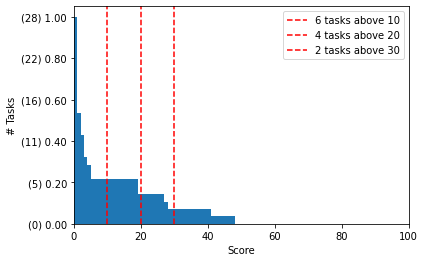

In [18]:
plot_cumulative_performance(scoring_non_mpc, ["exact_str_match"], tresholds=[10, 20, 30])
# For 3-shot, number of tasks above thresholds doubles vs 0-shot

{'auto_categorization': 1.3656397149000898,
 'codenames': 1.3122319986689366,
 'hindi_question_answering': 0.12301366558661819,
 'international_phonetic_alphabet_transliterate': 23.306149717605425,
 'language_games': 2.4929361696556676,
 'scientific_press_release': 0.9775131150884434,
 'semantic_parsing_in_context_sparc': 1.5050985778245853,
 'semantic_parsing_spider': 0.7276490529888654,
 'topical_chat': 1.624585043382689}

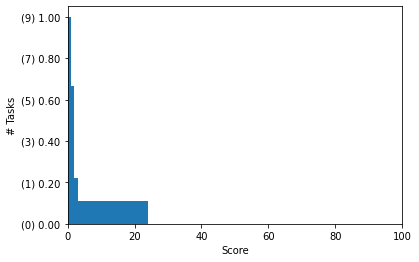

In [19]:
plot_cumulative_performance(scoring_non_mpc, ["bleu"])

{'bbq_lite': 18.33237579038372,
 'chess_state_tracking': 47.35294117647059,
 'conlang_translation': 39.8573547876847,
 'diverse_social_bias': 79.1280439164212,
 'factuality_of_summary': 50.54954954954955,
 'gem': 26.17426614955515,
 'gender_sensitivity_chinese': 75.30875321771775,
 'gender_sensitivity_english': 63.527406751208446,
 'language_games': 2.4929361696556676,
 'linguistic_mappings': 26.770833333333332,
 'list_functions': 3.9591315453384417,
 'modified_arithmetic': 18.333333333333336,
 'mult_data_wrangling': 4.67479674796748,
 'natural_instructions': 21.29049156523259,
 'simp_turing_concept': 40.66471163245357,
 'subject_verb_agreement': 59.41605596277577,
 'unnatural_in_context_learning': 4.39453125}

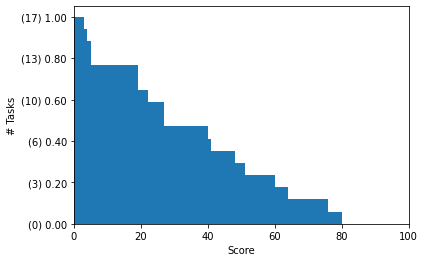

In [20]:
plot_cumulative_performance(scoring_non_mpc, ["normalized_aggregate_score"])

{'abstract_narrative_understanding': 33.33333333333333,
 'anachronisms': 50.0,
 'analogical_similarity': 20.123839009287924,
 'analytic_entailment': 42.857142857142854,
 'authorship_verification': 50.34090909090909,
 'bbq_lite_json': 29.66269841269841,
 'causal_judgment': 52.63157894736842,
 'cause_and_effect': 67.32026143790848,
 'cifar10_classification': 10.15625,
 'code_line_description': 26.666666666666668,
 'color': 5.56640625,
 'common_morpheme': 32.0,
 'conceptual_combinations': 40.978835978835974,
 'crash_blossom': 31.57894736842105,
 'crass_ai': 20.454545454545457,
 'cryobiology_spanish': 63.6986301369863,
 'cs_algorithms': 25.87890625,
 'dark_humor_detection': 50.0,
 'date_understanding': 56.36856368563685,
 'disambiguation_qa': 32.55813953488372,
 'discourse_marker_prediction': 13.302217036172696,
 'dyck_languages': 23.3,
 'elementary_math_qa': 21.666666666666668,
 'emoji_movie': 32.0,
 'emojis_emotion_prediction': 42.09923664122137,
 'empirical_judgments': 33.33333333333333

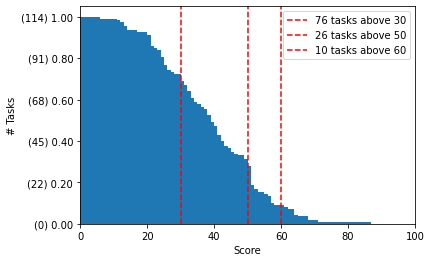

In [21]:
plot_cumulative_performance(set(task_types["multiple_choice"]), ["multiple_choice_grade"], tresholds=[30, 50, 60])
